# Continuous Time Sphere Model

We model the example of short-lived temperature sensors on the Earth in continuous time, using a combination of a queueing model and point process. Throughout the setup of the model, fix a time $T;$ for each time $t \in [0,T]$ the set of sensors $S_t$ at time $t$ is a set of locations on $\mathbb{S}^2,$ where $|S_t|$ is a random variable, and $S_t(i),$ the location of the $i$th sensor is uniformly sampled from the uniform measure on the sphere.

Perhaps the easiest way to set up the model is via a (FIFO) queueing model, or birth-death process representing the sensors:

- We start with $L_0$ number of sensors, each sampled uniformly from the sphere. 
- Sensors are added to the queue every so often, again sampled uniformly from the sphere. 
- Independently of the creation of new sensors, sensors break down at a perhaps different rate, and leave the queue.

We can model the time between consecutive joining/ exiting of the queue by exponential distributions.


## Queueing Model Implementation
Consider a queueing model whose initial length is $L_0,$ the number of initial sensors we begin with. We assume that the queue processes sensors (physically: sensors break down) in a random time $\sim \text{Exp}(\lambda_1),$ and sensors join the queue with interarrival times distributed according to $\text{Exp}(\lambda_2),$ which are independent of the times it takes for the queue to process the input.

We can simulate this queue in the following way. For a given fixed time $t \in [0,T],$ by the memoryless property of exponential distributions, the time until a sensor leaves the queue is still $X_1 \sim \text{Exp}(\lambda_1)$ and the interarrival time is still distributed according to $X_2 \text{Exp}(\lambda_2).$ Now, the time until one of these two actions occurs is a random variable $Z = \min(X_1,X_2) \sim \text{Exp}(\lambda_1+\lambda_2)$ (which can be checked). Now the probability that a sensor joins the queue first is $\mathbb{P}(X_1 > X_2) = \frac{\lambda_1}{\lambda_1 + \lambda_2},$ and one minus that for the probability that a sensor breaks and leaves the queue. We can then model the process by waiting $\text{Exp}(\lambda_1+\lambda_2)$ amount of time, and with probability $\frac{\lambda_1}{\lambda_1 + \lambda_2},$ adding a new sensor to the queue, or otherwise removing the oldest sensor from the queue.

## Dynamic Network Analysis
The continuous time model allows us to subsample as finely as we want. We keep track of the birth/death of the sensors in an interval tree; for any $t \in [0,T]$ we query the interval tree for the set of points that are present on the sphere at that time, and then create a dynamic network via the delaunay construction, assigining node values via some observation function representing temperature, or another desired quantity, and the edge weights by distance on the sphere.

# Run the Dynamic Network Analysis

In [1]:
from __future__ import division
import numpy as np
import sys
import os
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial.distance import squareform
import importlib
import scipy.spatial as sp

## Load in sphere code
sys.path.append('../2d_graph_example/')
import SphereExample as sphere
import ContinuousTimeSphereModel as ctsm

## Load in d.n. analysis code
sys.path.append('../shared_scripts/')
import graph_fns as gf
import persistence_fns as pf
import sliding_window_fns as sw
from ripser import ripser, plot_dgms
from sklearn import manifold

In [2]:
## Setup Sensor Lifetimes
T = 15 # Period 

obsfn = lambda t, p: sphere.periodic_northsouth_modulated(t,p,T)
edge_wtsfn = lambda hull_obj: sphere.get_edge_wts(hull_obj, alpha = 1.0)

lambda1 = 50
lambda2 = lambda1

sensor_lifetimes = ctsm.get_sensor_lifetimes(2.5*T, lambda1, lambda2)

In [3]:
## Create the Dynamic Network
dynamic_network_samples = 200
ts = np.linspace(0,2*T,dynamic_network_samples)

(node_wts,edge_wts, allpoints) = ctsm.sample_dynamic_network(sensor_lifetimes, ts, obsfn = obsfn,
                                    edge_wtsfn = edge_wtsfn)

In [107]:
## Apply the analysis

# apply phi functions, and scale the weights
phi_node_wts, phi_edge_wts = gf.weight_fn(node_wts, edge_wts, lamda=1, phi=sphere.linear_phi_fn)

# construct the filtrations / simplicial complexes according to our construction
filtration_matrix = list(map(lambda n, e: pf.get_filtration(n, e), phi_node_wts, phi_edge_wts))

# summarize these filtrations using H_0 barcodes
barcodes = list(map(pf.get_rips_complex, filtration_matrix))

In [96]:
## Video of the example

xs = []
for nw in phi_node_wts:
    xs += nw.tolist()
xs = np.array(xs)
nmin = np.min(xs)
nmax = np.max(xs)
plt.figure(figsize=(18, 6))
for i, (pts, nw, dgm) in enumerate(zip(allpoints, phi_node_wts, barcodes)):
    plt.clf()
    ax = plt.gcf().add_subplot(121, projection='3d')
    pts = np.concatenate((pts, np.zeros((2, 3))), 0)
    nw = np.concatenate((nw, np.array([nmin, nmax])))
    p = ax.scatter(pts[:, 0], pts[:, 1], pts[:, 2], c=nw, s=100, cmap=plt.get_cmap("magma"))
    plt.colorbar(p)
    hull = sp.ConvexHull(pts)
    for simplex in hull.simplices:
        ax.plot(pts[simplex, 0], pts[simplex, 1], pts[simplex, 2], 'k-')
    plt.title("Timestep %i"%i)
    plt.subplot(122)
    plot_dgms(dgm, labels=['H0'])
    plt.xlim([4, 12])
    plt.ylim([4, 12])
    plt.title("%i Nodes, %i Dots"%(nw.shape[0]-2, dgm.shape[0]))
    plt.savefig("Images/SphHarmCtsEx/%i.png"%i, bbox_inches='tight')

/Users/sianamuljadi/anaconda/lib/python3.6/site-packages/ripser-0.3.1-py3.6-macosx-10.7-x86_64.egg/ripser/ripser.py:341: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=10.0, right=10.0
  ax.set_xlim([x_down, x_up])
/Users/sianamuljadi/anaconda/lib/python3.6/site-packages/ripser-0.3.1-py3.6-macosx-10.7-x86_64.egg/ripser/ripser.py:342: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=10.0, top=10.0
  ax.set_ylim([y_down, y_up])
/Users/sianamuljadi/anaconda/lib/python3.6/site-packages/ripser-0.3.1-py3.6-macosx-10.7-x86_64.egg/ripser/ripser.py:341: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=10.0, right=10.0
  ax.set_xlim([x_down, x_up])
/Users/sianamuljadi/anaconda/lib/python3.6/site-packages/ripser-0.3.1-py3.6-macosx-10.7-x86_64.egg/ripser/ripser.py:342: UserWarning: At

# Vary Parameters

In [17]:
## Create the dynamic network
T = 10 # Period 

obsfn = lambda t, p: sphere.periodic_northsouth_modulated(t,p,T)
edge_wtsfn = lambda hull_obj: sphere.get_edge_wts(hull_obj, alpha = 1.0) #what is alpha?

lambda1 = 50
lambda2 = lambda1

sensor_lifetimes = ctsm.get_sensor_lifetimes(5*T, lambda1, lambda2)


## Vary Window Length and Dimension
window_length_test_values = np.linspace(0,2*T,19)[1:]
dim_test_values = range(4,20)

mpers_results = np.zeros((len(window_length_test_values),len(dim_test_values)))
top_diff_results = np.zeros((len(window_length_test_values),len(dim_test_values)))

for i,wl in enumerate(window_length_test_values):
    for j,d in enumerate(dim_test_values):
        print(wl,d)

        # resample dynamic network 
        tau = wl/d
        ts = np.arange(0,4*T,tau) 
        
        (node_wts,edge_wts, allpoints) = ctsm.sample_dynamic_network(sensor_lifetimes, ts, obsfn = obsfn,
                                    edge_wtsfn = edge_wtsfn)
        
        PDs = sphere.apply_pipeline(node_wts,edge_wts, d = d, tau = 1, lamda=1, phi=sphere.linear_phi_fn) # get the PDs
        res = (sphere.get_maximum_persistence(PDs)[1],sphere.get_top_diff_persistence(PDs)[1], sphere.get_num_features(PDs)[1])
        print(res)

        mpers_results[i,j] = res[0]
        top_diff_results[i,j] = res[1]

1.11111111111 4
(0.65168499946594238, 0.12511444091796875, 61)
1.11111111111 5
(0.66723895072937012, 0.089043378829956055, 81)
1.11111111111 6
(0.79808855056762695, 0.080408334732055664, 99)
1.11111111111 7
(1.0111181735992432, 0.24851155281066895, 113)
1.11111111111 8
(0.96992945671081543, 0.19436526298522949, 127)
1.11111111111 9
(1.0387334823608398, 0.1576075553894043, 145)
1.11111111111 10
(1.2829585075378418, 0.36514019966125488, 153)
1.11111111111 11
(1.1549654006958008, 0.27648305892944336, 175)
1.11111111111 12
(1.6499936580657959, 0.60654449462890625, 180)
1.11111111111 13
(1.5224330425262451, 0.25348877906799316, 179)
1.11111111111 14
(1.753277063369751, 0.54421043395996094, 213)
1.11111111111 15
(1.7081396579742432, 0.6843268871307373, 222)
1.11111111111 16
(1.6464037895202637, 0.36028623580932617, 237)
1.11111111111 17
(1.8531863689422607, 0.66886162757873535, 241)
1.11111111111 18
(1.8963313102722168, 0.48339486122131348, 243)
1.11111111111 19
(2.0573220252990723, 0.710978

(2.1321125030517578, 1.8028512001037598, 6)
10.0 11
(2.7020244598388672, 2.0920600891113281, 7)
10.0 12
(2.8902328014373779, 2.3059329986572266, 9)
10.0 13
(3.1898567676544189, 2.5609221458435059, 9)
10.0 14
(3.4210634231567383, 2.6883766651153564, 20)
10.0 15
(3.6785397529602051, 3.039097785949707, 21)
10.0 16
(3.6901979446411133, 3.1476154327392578, 22)
10.0 17
(3.9878947734832764, 3.565354585647583, 25)
10.0 18
(3.9828495979309082, 3.4750070571899414, 29)
10.0 19
(4.2684836387634277, 3.7656331062316895, 32)
11.1111111111 4
(0.86215353012084961, 0.86215353012084961, 1)
11.1111111111 5
(1.0412769317626953, 1.0410699844360352, 2)
11.1111111111 6
(1.2290580272674561, 1.1119215488433838, 2)
11.1111111111 7
(1.3278553485870361, 1.3278553485870361, 1)
11.1111111111 8
(1.4456937313079834, 1.3406209945678711, 2)
11.1111111111 9
(1.4916849136352539, 1.3424973487854004, 6)
11.1111111111 10
(1.9493165016174316, 1.5480704307556152, 6)
11.1111111111 11
(2.5052804946899414, 1.7645125389099121, 6)


(3.027245044708252, 2.3214621543884277, 7)
20.0 4
(0, 0, 0)
20.0 5
(0.080127239227294922, 0.080127239227294922, 1)
20.0 6
(0, 0, 0)
20.0 7
(0.69820261001586914, 0.69820261001586914, 1)
20.0 8
(0.18928718566894531, 0.18928718566894531, 1)
20.0 9
(1.3073983192443848, 1.3073983192443848, 1)
20.0 10
(0.44124174118041992, 0.44124174118041992, 1)
20.0 11
(1.747321605682373, 1.747321605682373, 1)
20.0 12
(1.0173606872558594, 0.98499536514282227, 2)
20.0 13
(2.4717822074890137, 2.4717822074890137, 1)
20.0 14
(1.7191882133483887, 1.5927810668945312, 3)
20.0 15
(2.6199121475219727, 2.6199121475219727, 1)
20.0 16
(2.1728649139404297, 1.9415616989135742, 4)
20.0 17
(3.1898837089538574, 3.1898837089538574, 1)
20.0 18
(2.5340495109558105, 2.0354127883911133, 5)
20.0 19
(3.1875171661376953, 3.1061396598815918, 2)


/Users/sianamuljadi/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide


<Figure size 432x288 with 0 Axes>

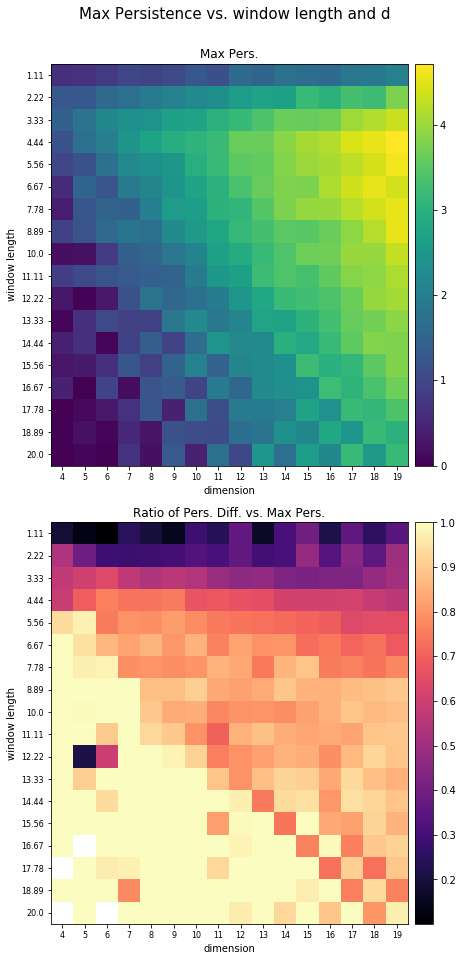

In [18]:
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable

plt.gcf().clear()
fig, axs = plt.subplots(2,1, figsize = (7,14))

ticksize = 8

im1 = axs[0].imshow(mpers_results)

axs[0].set_xlabel('dimension')
axs[0].set_xticks(np.arange(len(dim_test_values)))
axs[0].set_xticklabels(labels = list(dim_test_values),fontsize = ticksize)

axs[0].set_ylabel('window length')
axs[0].set_yticks(np.arange(len(window_length_test_values)))
axs[0].set_yticklabels(labels = list(np.around(window_length_test_values,2)),fontsize = ticksize)

axs[0].set_title('Max Pers.')

divider1 = make_axes_locatable(axs[0])
cax1 = divider1.append_axes('right', size='5%', pad=0.1)
fig.colorbar(im1,cax1,orientation = 'vertical')

### Do the other plot ###

im2 = axs[1].imshow(np.divide(top_diff_results,mpers_results),cmap = plt.cm.magma)

axs[1].set_xlabel('dimension')
axs[1].set_xticks(np.arange(len(dim_test_values)))
axs[1].set_xticklabels(labels = list(dim_test_values), fontsize = ticksize)


axs[1].set_ylabel('window length')
axs[1].set_yticks(np.arange(len(window_length_test_values)))
axs[1].set_yticklabels(labels = list(np.around(window_length_test_values,2)),fontsize = ticksize)
axs[1].set_title('Ratio of Pers. Diff. vs. Max Pers.')

divider2 = make_axes_locatable(axs[1])
cax2 = divider2.append_axes('right', size='5%', pad=0.1)
fig.colorbar(im2,cax2)

fig.tight_layout(rect=[0, 0.03, 1, 0.95])

fig.suptitle('Max Persistence vs. window length and d', fontsize = 15)
plt.savefig('CtsEx:wl{}dim{}T{}'.format(len(window_length_test_values),len(dim_test_values),T))

plt.show()

### Try to normalize by dimension? 

Goal is to identify which value of window length maximizes max pers for each value of dimension